# Canadian Extreme Precipitation: station analysis

This note explores station data used in the Canadian Extreme Precipitation paper led by Mark Serreze.  This is an analysis of the integrity of the data.  There are several objectives.

1. Evaluate the homogeneity of station data
    a. correlation between overlaping station record
    b. Tolerance of precipitation measurements
2. Explore statistics of the dataset

In [85]:
import sys
sys.path.append('../canadian_extreme_precip/')

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import pandas as pd

from reader import read_combined_file
from filepath import combined_station_filepath

In [6]:
stations_list = [
    'cape dyer',
    'resolute bay',
    'eureka',
    'alert',
    'clyde river',
    'cambridge bay',
    'hall beach',
    'sachs harbour',
    'inuvik',
    'pond inlet',
    ]

In [30]:
def load_precipitation(station):
    """Loads precipitation data"""
    df = read_combined_file(combined_station_filepath(station))
    return df['TOTAL_PRECIPITATION']

def check_resolution(ts):
    """Returns series showing whether resolution (numerical precision) is mm or tenths of mm"""
    return ts == ts.astype(int)

def ismm(ts):
    return check_resolution(ts)

def istenth(ts):
    return check_resolution(ts) == False

## Measurement Tolerance

In [101]:
for station in stations_list:
    total_precip = load_precipitation(station)
    total_precip = total_precip[total_precip > 0.]  # Only use wet days
    n = len(total_precip)
    print(f"{station.title():15s} {ismm(total_precip).sum()*100./n:5.1f} {istenth(total_precip).sum()*100./n:5.1f}")

Cape Dyer        12.8  87.2
Resolute Bay     11.2  88.8
Eureka            9.1  90.9
Alert            12.0  88.0
Clyde River      13.6  86.4
Cambridge Bay    10.7  89.3
Hall Beach       12.4  87.6
Sachs Harbour    11.7  88.3
Inuvik           17.4  82.6
Pond Inlet       26.0  74.0


0.09141750914175091


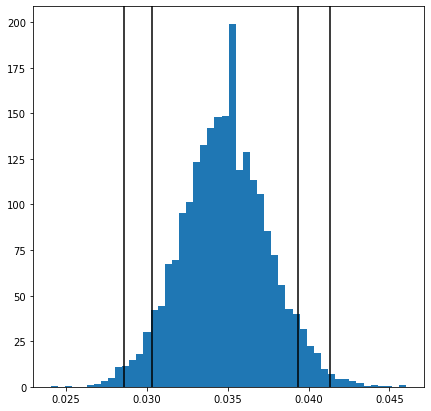

In [156]:
station='eureka'
total_precip = load_precipitation(station)
total_precip = total_precip[total_precip > 0.]  # Only use wet days
n = len(total_precip)
fwhole = ismm(total_precip).sum() / n 
print(fwhole)

dist = getattr(stats, "exponweib")
parameters = dist.fit(total_precip)
rv = dist(*parameters)
#x = np.round(dist.rvs(, size=len(total_precip)), 1)
#print(ismm(x).sum()*100./len(total_precip))

def test_statistic(dist, n=7000):
    x = np.round(dist.rvs(size=n), 1) 
    return ismm(x).sum() / n

sample = 5000
fraction_whole_mm = [test_statistic(rv, n=n) for i in range(sample)] 

#print(f"{'Test':15s} {ismm(x).sum()*100./n:5.1f} {istenth(x).sum()*100./n:5.1f}")

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(fraction_whole_mm, bins=50, density=True);
q = np.quantile(fraction_whole_mm, [0.01, 0.05, 0.95, 0.99])
for qq in q:
    ax.axvline(qq, c='k')
#ax.scatter(fwhole, 0.1, s=100, c='k')

For most stations, roughly 10% of measurements a whole millimeters, the rest obviously are to 0.1 mm.  Inuvik and Pond Inlet (which we don't include in the paper) are higher at ~20%.  10% is the expected number of whole millimeters if 7000 random variates are selected from a uniform distribution.  My test here is

In [154]:
precision_mm = ismm(total_precip)
precision_tenths = istenth(total_precip)
print(f"Whole mm: {precision_mm.sum()}")
print(f"Tenths mm: {precision_tenths.sum()}")

Whole mm: 425
Tenths mm: 4224


/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


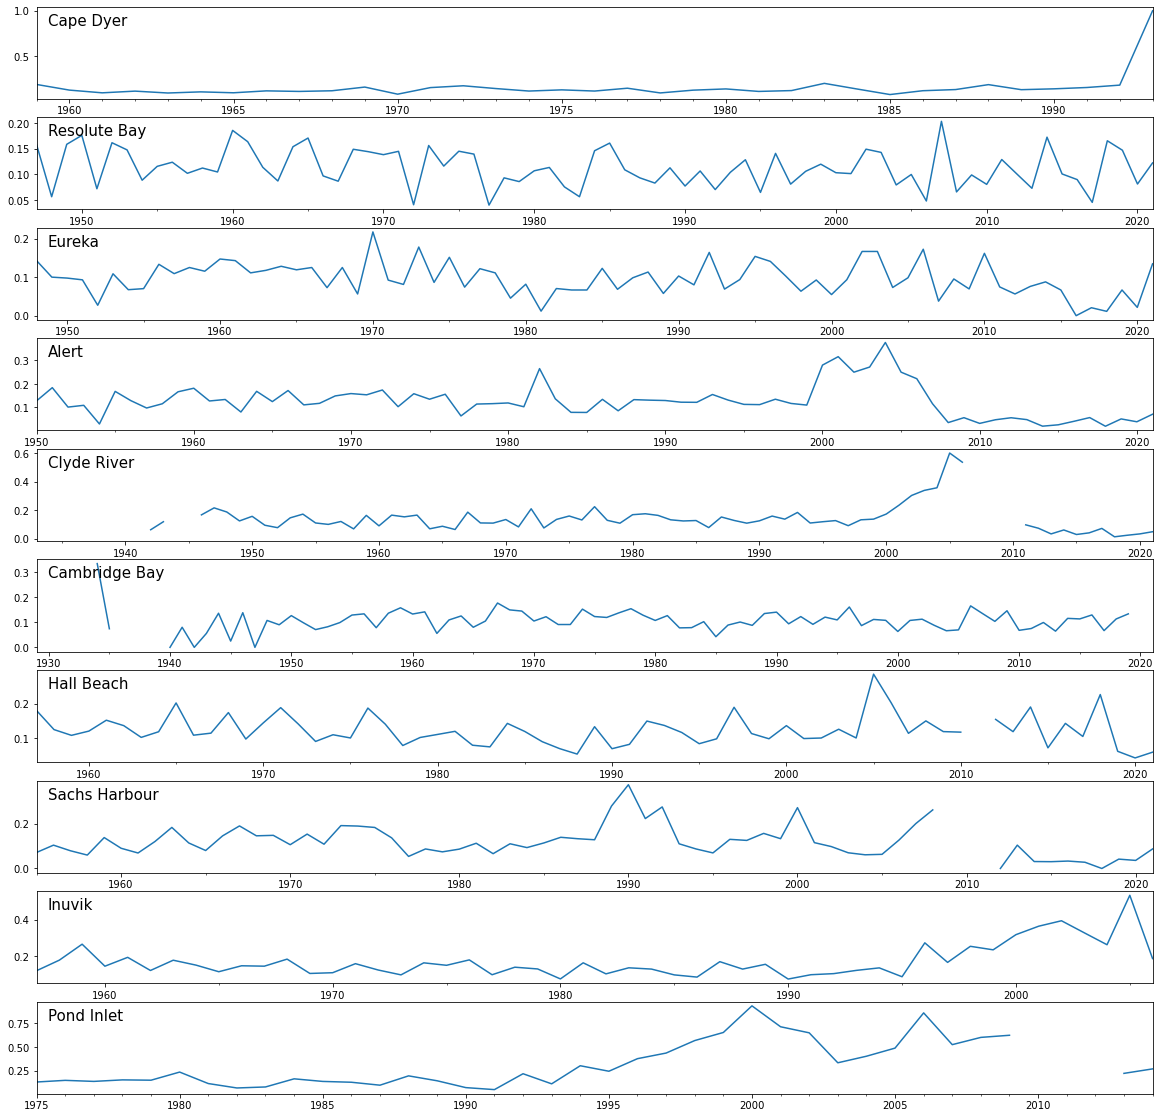

In [164]:
def get_fraction(x):
    return x.sum() / x.count()

fig, axes = plt.subplots(10, 1, figsize=(20,20))

for ax, station in zip(axes.flatten(), stations_list):
    total_precip = load_precipitation(station)
    total_precip = total_precip[total_precip > 0.]  # Only use wet days
    precision_mm = ismm(total_precip)
    precision_mm.resample('Y').apply(get_fraction).plot(ax=ax)
    ax.text(0.01, 0.8, station.title(), transform=ax.transAxes, fontsize=15)
    
#ax.scatter(x=precision_mm.index, y=precision_mm, s=1)

In [79]:
from scipy.stats import gamma, expon, exponweib

## Fit candidate distributions

In [123]:
for dist_name in ["gamma", "expon", "exponweib"]:
    dist = getattr(stats, dist_name)
    parameters = dist.fit(total_precip)
    rv = dist(*parameters)
    a = stats.kstest(total_precip, dist_name, args=parameters)
    print(f"{dist_name:15s} {parameters}")
    print(f"{dist_name:15s} {a.statistic} {a.pvalue}")

gamma           (0.39013594895991954, 0.09999999999999999, 1.5630296109707902)
gamma           0.40666195684280637 0.0
expon           (0.1, 1.974932432432432)
expon           0.1819695059298035 1.468887985541201e-85
exponweib       (1.5531701119857693, 0.6405249368231543, 0.09999999999999999, 1.0018110425100417)
exponweib       0.08757911408559904 3.810840598199086e-20


/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))


In [117]:
def test_and_plot_distributions(station, pthreshold=0., 
                                distributions=["gamma", "expon", "exponweib"],
                               ax=ax):
    """Estimates best distribution for rainfall data"""
    
    total_precip = load_precipitation(station)
    total_precip = total_precip[total_precip > 0.]
    
    bins = np.arange(0.1, np.ceil(total_precip.max())+1, 1.)
    x = bins + 0.5
    
    total_precip.hist(bins=bins, ax=ax, density=True, alpha=0.5)

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        parameters = dist.fit(total_precip)
        a = stats.kstest(total_precip, dist_name, args=parameters)
        rv = dist(*parameters)
        ax.plot(x, rv.pdf(x), lw=2, label=f"{dist_name}: {a.statistic:0.2f}({a.pvalue:0.2f})")
    ax.legend()
    ax.set_title(station.title())
    
    return ax

/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/apbarret/anaconda3/envs/rain_on_snow_tmp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1608: RuntimeWarning: invalid value encountered in add
  negxc + sc.xlogy(c - 1.0, x))
/home/apbarret/anaco

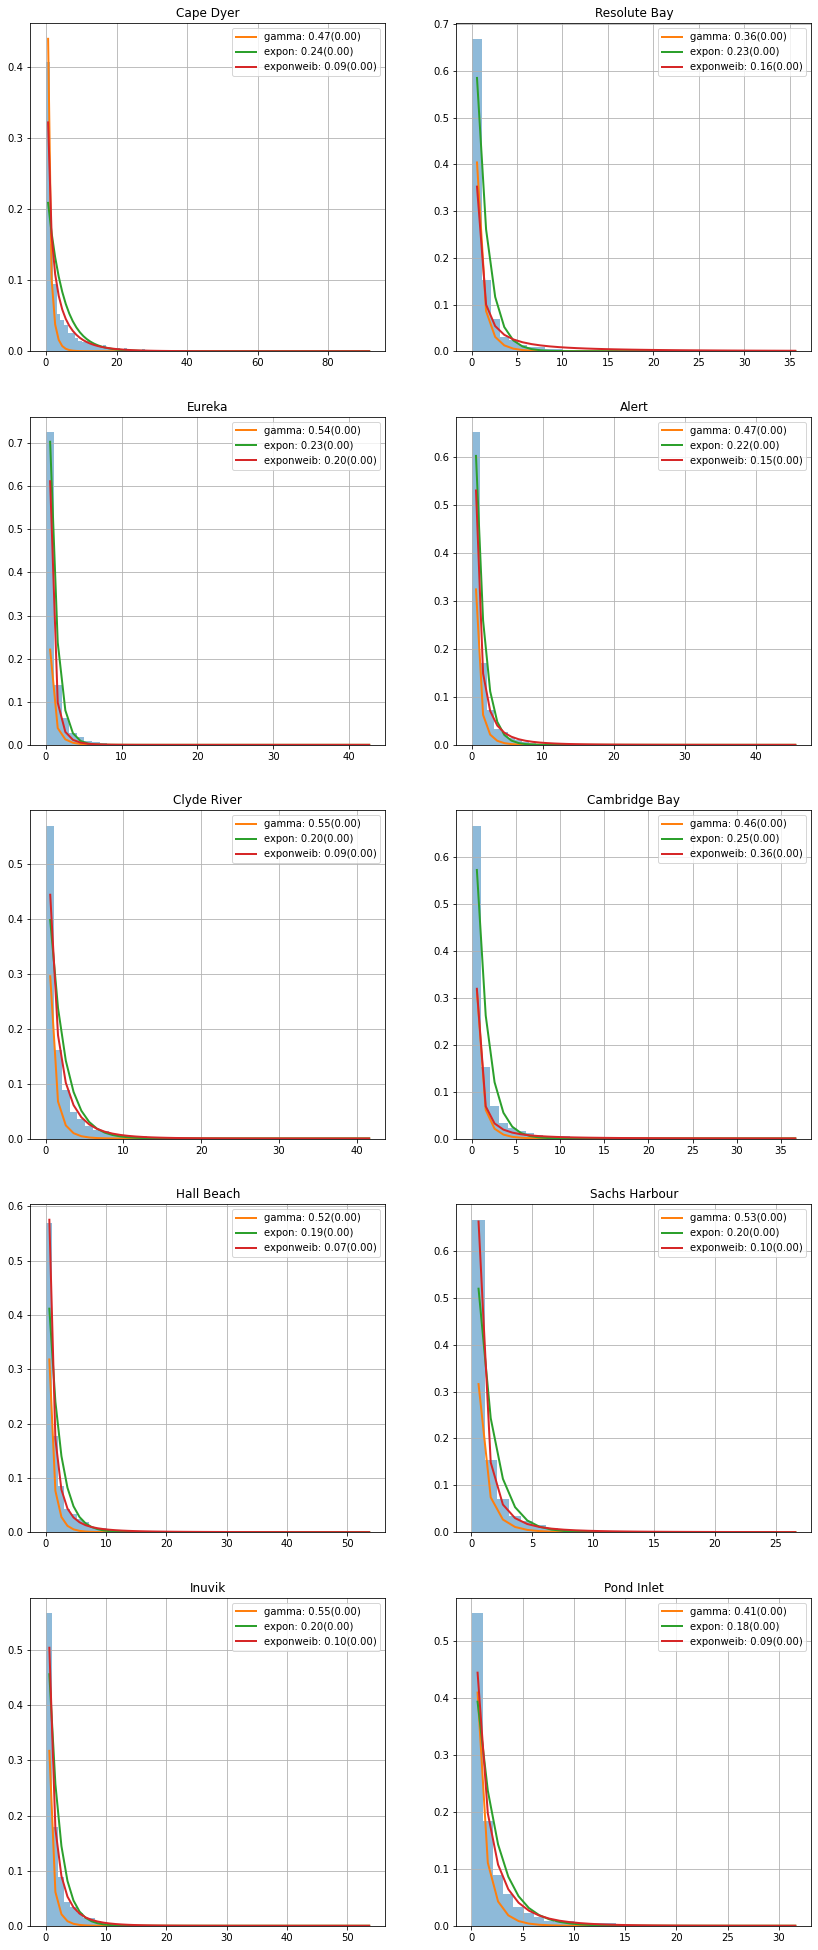

In [120]:
fig, axes = plt.subplots(5, 2, figsize=(14,35))
for ax, station in zip(axes.flatten(), stations_list):
    test_and_plot_distributions(station, ax=ax)